In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import random
import time
import joblib
import os
from utils import render_single, render_multiple, get_dataset_files, extract_random_entries, extract_first_entries, generate_pixel_columns
from IPython.display import display, Image as IPImage

In [2]:
num_cats = 50
entries_per_cat = 1000

files = get_dataset_files()
files = random.choices(files, k=num_cats)
# files = ['./dataset/bat.ndjson', './dataset/snowman.ndjson', './dataset/spider.ndjson', './dataset/strawberry.ndjson', './dataset/guitar.ndjson']
data = [extract_first_entries(file, entries_per_cat, recognized=True) for file in files]
flat_data = [item for sublist in data for item in sublist]
df_loaded = pd.DataFrame.from_dict(flat_data, orient='columns')
print(f'Loaded {len(df_loaded)} entries from {files}')

Loaded 50000 entries from ['./dataset/octagon.ndjson', './dataset/school bus.ndjson', './dataset/goatee.ndjson', './dataset/toaster.ndjson', './dataset/van.ndjson', './dataset/cello.ndjson', './dataset/television.ndjson', './dataset/square.ndjson', './dataset/wristwatch.ndjson', './dataset/passport.ndjson', './dataset/square.ndjson', './dataset/submarine.ndjson', './dataset/backpack.ndjson', './dataset/fence.ndjson', './dataset/aircraft carrier.ndjson', './dataset/toothbrush.ndjson', './dataset/drums.ndjson', './dataset/star.ndjson', './dataset/couch.ndjson', './dataset/lightning.ndjson', './dataset/basketball.ndjson', './dataset/sheep.ndjson', './dataset/stereo.ndjson', './dataset/calculator.ndjson', './dataset/hockey stick.ndjson', './dataset/zebra.ndjson', './dataset/cake.ndjson', './dataset/hot dog.ndjson', './dataset/blackberry.ndjson', './dataset/clarinet.ndjson', './dataset/calculator.ndjson', './dataset/computer.ndjson', './dataset/screwdriver.ndjson', './dataset/horse.ndjson',

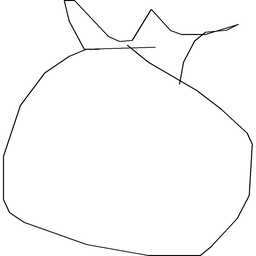

blueberry


In [70]:
img = random.choice(flat_data)
display(IPImage(render_single(img['drawing'])))
print(img['word'])

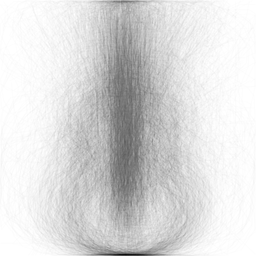

1000 superimposed cellos.


In [4]:
count = 1000 if entries_per_cat > 1000 else entries_per_cat
word = random.choice(df_loaded['word'].values)
imgs = df_loaded[df_loaded['word'] == word].sample(count)
display(IPImage(render_multiple(imgs['drawing'])))
print(f'{count} superimposed {word}s.')

In [71]:
df = df_loaded.sample(len(df_loaded))
print('Done shuffling dataset')
df = generate_pixel_columns(df, resolution=64, invert_color=True, stroke_width_scale=2)
print('Done generating pixel columns')
df = df.reset_index()

train_amt = int(len(df) * .9)

train = df[:train_amt]
test = df[train_amt:]
# del df

train = train.reset_index()
test = test.reset_index()

print(f'Train: {len(train)} entries, test: {len(test)} entries.')

Done shuffling dataset
Done generating pixel columns
Train: 45000 entries, test: 5000 entries.


In [72]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca_on = True
save_to_disk = True

if save_to_disk:
    stamp = str(int(time.time()))
    folder = f'./runs/{stamp}/'
    if not os.path.exists(folder):
        os.makedirs(folder)
    pd.DataFrame.to_feather(df, folder + 'data')
    print('Done saving dataset to disk')

y = train['word']
X = train.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word'])

if pca_on:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    pca = PCA(.85)
    X = pca.fit_transform(X)
    print(f'Keeping {pca.n_components_} features')
    if save_to_disk:
        joblib.dump(pca, folder + 'pca')
        joblib.dump(pca, folder + 'scaler')

# classifier = LinearSVC(random_state=0, max_iter=100000, dual=False)
# classifier = NuSVC(nu=.1, max_iter=10000)
# classifier = SGDClassifier(loss='epsilon_insensitive', penalty='elasticnet', n_jobs=-1)
classifier = SVC(kernel='rbf', decision_function_shape='ovr')
model = OneVsRestClassifier(classifier, n_jobs=-1).fit(X, y)
if save_to_disk: joblib.dump(model, folder + 'model')

Done saving dataset to disk
Keeping 646 features


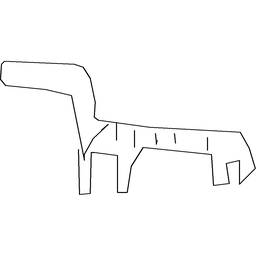

zebra
zebra == zebra ? True


In [ ]:
sample = test.sample(1)
sample_predict = sample.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word'])

if pca_on:
    sample_predict = scaler.transform(sample_predict)
    sample_predict = pca.transform(sample_predict)

prediction = model.predict(sample_predict)
display(IPImage(render_single(sample['drawing'].iloc[0])))
print(prediction[0])
print(f"{sample['word'].iloc[0]} == {prediction[0]} ? {sample['word'].iloc[0] == prediction[0]}")

In [ ]:
test2 = test.drop(columns=['countrycode', 'timestamp', 'recognized', 'key_id', 'drawing', 'word'])
if pca_on:
    test2 = scaler.transform(test2)
    test2 = pca.transform(test2)
prediction = model.predict(test2)

from sklearn.metrics import accuracy_score
acc_score = accuracy_score(test['word'].values.tolist(), prediction)
print(f"Accuracy score: {acc_score}")

Accuracy score: 0.7506
